In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Read in training data
data = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
# Create X which does not have the 'answers' and y which only has the answers
X = data.drop(['Survived'], axis=1)
y = data[['Survived']]

In [4]:
# Splitting the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state=10)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((712, 11), (712, 1), (179, 11), (179, 1))

In [5]:
# Concat the trains and vals together
df_train = pd.concat([X_train, y_train], axis = 1)
df_val = pd.concat([X_val, y_val], axis = 1)

# Separating y_train and y_val into arrays
y_train = df_train['Survived']
y_val = df_val['Survived']

## Manually Fixing all data

* Change Sex to Numerical

In [6]:
# Reassign 'Male/Female' as 1/0 in Train and Val
df_train['Sex'] = df_train['Sex'].replace({'male' : 1, 'female': 0})
df_train['Sex'] = df_train['Sex'].astype(int)

df_val['Sex'] = df_val['Sex'].replace({'male' : 1, 'female': 0})
df_val['Sex'] = df_val['Sex'].astype(int)

* Fill Nan Ages with Ages corresponding to Class and Survival

In [7]:
# Manually changing Nan in Age to mean values
c1_s1_median = round(df_train.loc[(df_train['Survived']==1) & (df_train['Pclass']==1)]['Age'].median(), 0)
c1_s0_median = round(df_train.loc[(df_train['Survived']==0) & (df_train['Pclass']==1)]['Age'].median(), 0)
c2_s1_median = round(df_train.loc[(df_train['Survived']==1) & (df_train['Pclass']==2)]['Age'].median(), 0)
c2_s0_median = round(df_train.loc[(df_train['Survived']==1) & (df_train['Pclass']==2)]['Age'].median(), 0)
c3_s1_median = round(df_train.loc[(df_train['Survived']==1) & (df_train['Pclass']==3)]['Age'].median(), 0)
c3_s0_median = round(df_train.loc[(df_train['Survived']==1) & (df_train['Pclass']==3)]['Age'].median(), 0)

# Inserting the mean values in for the missing (Nan) values
df_train.loc[(df_train['Survived'] == 1) & (df_train['Pclass']==1) & (df_train.Age.isna()), 'Age'] = c1_s1_median
df_train.loc[(df_train['Survived'] == 0) & (df_train['Pclass']==1) & (df_train.Age.isna()), 'Age'] = c1_s0_median
df_train.loc[(df_train['Survived'] == 1) & (df_train['Pclass']==2) & (df_train.Age.isna()), 'Age'] = c2_s1_median
df_train.loc[(df_train['Survived'] == 0) & (df_train['Pclass']==2) & (df_train.Age.isna()), 'Age'] = c2_s0_median
df_train.loc[(df_train['Survived'] == 1) & (df_train['Pclass']==3) & (df_train.Age.isna()), 'Age'] = c3_s1_median
df_train.loc[(df_train['Survived'] == 0) & (df_train['Pclass']==3) & (df_train.Age.isna()), 'Age'] = c3_s0_median

# Inserting the mean values DERIVED ONLY FROM TRAINING DATA into validation data
df_val.loc[(df_val['Survived'] == 1) & (df_val['Pclass']==1) & (df_val.Age.isna()), 'Age'] = c1_s1_median
df_val.loc[(df_val['Survived'] == 0) & (df_val['Pclass']==1) & (df_val.Age.isna()), 'Age'] = c1_s0_median
df_val.loc[(df_val['Survived'] == 1) & (df_val['Pclass']==2) & (df_val.Age.isna()), 'Age'] = c2_s1_median
df_val.loc[(df_val['Survived'] == 0) & (df_val['Pclass']==2) & (df_val.Age.isna()), 'Age'] = c2_s0_median
df_val.loc[(df_val['Survived'] == 1) & (df_val['Pclass']==3) & (df_val.Age.isna()), 'Age'] = c3_s1_median
df_val.loc[(df_val['Survived'] == 0) & (df_val['Pclass']==3) & (df_val.Age.isna()), 'Age'] = c3_s0_median

* Change Cabins columns to numerical values

In [8]:
# Creating a new column called Deck which correlates to the first letter in Cabin column
# If the value in the column is null, it is replaced with M for Missing
# Original code found here:
# https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial#1.-Exploratory-Data-Analysis

df_train['Deck'] = df_train['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

# Grouping by decks and dropping columns to run into functions
df_all_decks = df_train.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 
                                                                          'SibSp', 'Parch', 'Fare', 
                                                                          'Embarked', 'Cabin', 'PassengerId', 
                                                                          'Ticket']).rename(columns={'Name': 'Count'}).transpose()
def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}
    
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)

idx = df_train[df_train['Deck'] == 'T'].index
df_train.loc[idx, 'Deck'] = 'A'

df_all_decks_survived = df_train.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 
                                                                                          'Parch', 'Fare', 'Embarked', 
                                                                                          'Pclass', 'Cabin', 'PassengerId', 
                                                                                          'Ticket']).rename(columns={'Name':'Count'}).transpose()

df_train['Deck'] = df_train['Deck'].replace(['A', 'B', 'C'], '0')
df_train['Deck'] = df_train['Deck'].replace(['D', 'E'], '1')
df_train['Deck'] = df_train['Deck'].replace(['F', 'G'], '2')
df_train['Deck'] = df_train['Deck'].replace(['M'], '3')

df_train.drop(['Cabin'], inplace=True, axis=1)

In [9]:
# Do the same for Validation
df_val['Deck'] = df_val['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df_all_decks = df_val.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 
                                                                          'SibSp', 'Parch', 'Fare', 
                                                                          'Embarked', 'Cabin', 'PassengerId', 
                                                                          'Ticket']).rename(columns={'Name': 'Count'}).transpose()
def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}
    
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages
   

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)

idx = df_val[df_val['Deck'] == 'T'].index
df_val.loc[idx, 'Deck'] = 'A'

df_all_decks_survived = df_val.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 
                                                                                          'Parch', 'Fare', 'Embarked', 
                                                                                          'Pclass', 'Cabin', 'PassengerId', 
                                                                                          'Ticket']).rename(columns={'Name':'Count'}).transpose()

df_val['Deck'] = df_val['Deck'].replace(['A', 'B', 'C'], '0')
df_val['Deck'] = df_val['Deck'].replace(['D', 'E'], '1')
df_val['Deck'] = df_val['Deck'].replace(['F', 'G'], '2')
df_val['Deck'] = df_val['Deck'].replace(['M'], '3')

df_val.drop(['Cabin'], inplace=True, axis=1)

# Using Scikit Learn's Random Forest

In [10]:
# Preparing subDataFrames to test how many variables could be best
df_forest_3 = df_train[['Pclass', 'Fare', 'Age']]
df_forest_4 = df_train[['Pclass', 'Fare', 'Age', 'Sex']]
df_forest_5 = df_train[['Pclass', 'Fare', 'Age', 'Sex', 'Deck']]

df_my_opinion_best_train = df_train[['Sex', 'Fare', 'Deck', 'Age']]

In [11]:
df_forest_val_3 = df_val[['Pclass', 'Fare', 'Age']]
df_forest_val_4 = df_val[['Pclass', 'Fare', 'Age', 'Sex']]
df_forest_val_5 = df_val[['Pclass', 'Fare', 'Age', 'Sex', 'Deck']]

df_my_opinion_best = df_val[['Sex', 'Fare', 'Deck', 'Age']]

#### Fitting to Train Data

In [12]:
rf3 = RandomForestClassifier(n_estimators=500, max_depth=5)
rf3.fit(df_forest_3, y_train)
round(rf3.score(df_forest_3, y_train),3)

0.765

In [13]:
rf4 = RandomForestClassifier(n_estimators=500, max_depth=8)
rf4.fit(df_forest_4, y_train)
round(rf4.score(df_forest_4, y_train),3)

0.917

In [14]:
rf5 = RandomForestClassifier(n_estimators=500, max_depth=8)
rf5.fit(df_forest_5, y_train)
round(rf5.score(df_forest_5, y_train),3)

0.916

In [15]:
rf_guess = RandomForestClassifier(n_estimators=500, max_depth=8)
rf_guess.fit(df_my_opinion_best_train, y_train)
round(rf_guess.score(df_my_opinion_best_train, y_train),3)

0.892

#### Testing vs. Validation Data

In [16]:
# 'Pclass', 'Fare', 'Age'
print(rf3.feature_importances_)
print(round(rf3.score(df_forest_val_3, y_val),3))

[0.2431923  0.43622257 0.32058513]
0.804


In [17]:
# 'Pclass', 'Fare', 'Age', 'Sex'
print(rf4.feature_importances_)
print(round(rf4.score(df_forest_val_4, y_val),3))

[0.12532597 0.2745916  0.25133873 0.3487437 ]
0.888


In [18]:
# 'Pclass', 'Fare', 'Age', 'Sex', 'Deck'
print(rf5.feature_importances_)
print(round(rf5.score(df_forest_val_5, y_val),3))

[0.10569612 0.24578774 0.22872073 0.34968751 0.0701079 ]
0.872


In [19]:
# 'Sex', 'Fare', 'Deck', 'Age'
print(rf_guess.feature_importances_)
print(round(rf_guess.score(df_my_opinion_best, y_val),3))

[0.37266436 0.28999388 0.09774374 0.23959802]
0.86


<AxesSubplot: >

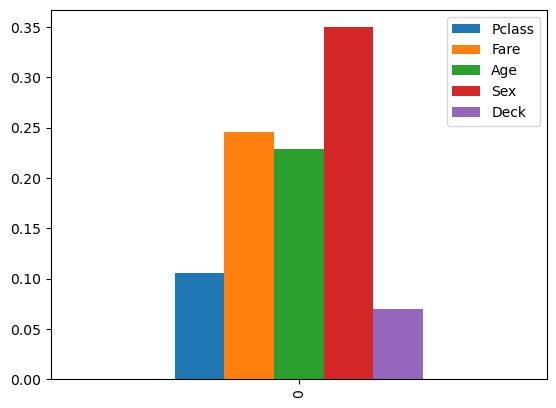

In [20]:
pd.DataFrame([rf5.feature_importances_], columns=['Pclass', 'Fare', 'Age', 'Sex', 'Deck']).plot.bar()

# Going through the steps with the test data

### Steps

* Replace Sex with numbers
* Replace Nan Ages with median values
* Replace Cabin with Deck numbers
* Fill Nan Fare Values with median for each class
* Create DataFrame using modified columns [['Sex', 'Fare', 'Deck', 'Age']]
* Create tests using RandomTree knowledge

In [21]:
# Find medians to use
c1_s1_median, c1_s0_median, c2_s1_median, c2_s0_median, c3_s1_median, c3_s0_median

(35.0, 44.0, 28.0, 28.0, 22.0, 22.0)

In [22]:
# Define new Median/Avg to use
c1_median_avg = (35+44)/2

In [23]:
# Replace Sex
test['Sex'] = test['Sex'].replace({'male' : 1, 'female': 0})
test['Sex'] = test['Sex'].astype(int)

In [24]:
# Fill in Nan Ages
test.loc[(test['Pclass']==1) & (test.Age.isna()), 'Age'] = c1_median_avg
test.loc[(test['Pclass']==2) & (test.Age.isna()), 'Age'] = c2_s1_median
test.loc[(test['Pclass']==3) & (test.Age.isna()), 'Age'] = c3_s1_median

In [25]:
# Change Cabin to Deck
test['Deck'] = test['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df_all_decks = test.groupby(['Deck', 'Pclass']).count().drop(columns=['Sex', 'Age', 
                                                                      'SibSp', 'Parch', 'Fare', 
                                                                      'Embarked', 'Cabin', 'PassengerId', 
                                                                      'Ticket']).rename(columns={'Name': 'Count'}).transpose()
def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}
    
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages
   

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)

idx = test[test['Deck'] == 'T'].index
test.loc[idx, 'Deck'] = 'A'

df_all_decks_survived = test.groupby(['Deck']).count().drop(columns=['Sex', 'Age', 'SibSp', 
                                                                                 'Parch', 'Fare', 'Embarked', 
                                                                                 'Pclass', 'Cabin', 'PassengerId', 
                                                                                 'Ticket']).rename(columns={'Name':'Count'}).transpose()

test['Deck'] = test['Deck'].replace(['A', 'B', 'C'], '0')
test['Deck'] = test['Deck'].replace(['D', 'E'], '1')
test['Deck'] = test['Deck'].replace(['F', 'G'], '2')
test['Deck'] = test['Deck'].replace(['M'], '3')

test.drop(['Cabin'], inplace=True, axis=1)

In [26]:
# Filling Nan Fare
c1_fare_median = round(df_train.loc[(df_train['Pclass']==1)]['Fare'].median(), 0)
c2_fare_median = round(df_train.loc[(df_train['Pclass']==2)]['Fare'].median(), 0)
c3_fare_median = round(df_train.loc[(df_train['Pclass']==3)]['Fare'].median(), 0)

test.loc[(test['Pclass']==1) & (test.Fare.isna()), 'Fare'] = c1_fare_median
test.loc[(test['Pclass']==2) & (test.Fare.isna()), 'Fare'] = c2_fare_median
test.loc[(test['Pclass']==3) & (test.Fare.isna()), 'Fare'] = c3_fare_median

In [27]:
test_3 = test[['Pclass', 'Fare', 'Age']]
test_4 = test[['Pclass', 'Fare', 'Age', 'Sex']]
test_5 = test[['Pclass', 'Fare', 'Age', 'Sex', 'Deck']]

my_test = test[['Sex', 'Fare', 'Deck', 'Age']]

In [28]:
test3_pred = pd.DataFrame(rf3.predict(test_3))
test3_pred

,0
0,0
1,0
2,0
3,0
4,0
...,...
413,0
414,1
415,0
416,0


In [29]:
test4_pred = pd.DataFrame(rf4.predict(test_4))
test4_pred

,0
0,0
1,0
2,0
3,0
4,1
...,...
413,0
414,1
415,0
416,0


In [30]:
test5_pred = pd.DataFrame(rf5.predict(test_5))
test5_pred

,0
0,0
1,0
2,0
3,0
4,1
...,...
413,0
414,1
415,0
416,0


In [31]:
my_test_pred = pd.DataFrame(rf_guess.predict(my_test))
my_test_pred

,0
0,0
1,0
2,0
3,0
4,1
...,...
413,0
414,1
415,0
416,0
